# ensembling and stochasticity v2

In [1]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
import os
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal as mvn
colors =plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
warnings.filterwarnings('ignore') #ignore overflow warnings



### Misc functions

In [2]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def log_flat_one(x,low,high): #set prior to 1 for these pure optimization examples
    n=x.shape[-1]
    return 0

def get_metrics(trace,verbose=True):
    #add maxp point
    maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
    maxidx=np.argmax(trace['logp'][0]['q{0}'.format(maxq)])
    s_maxp = trace['q_samples'][0]['q{0}'.format(maxq)][maxidx]
    maxp = trace['logp'][0]['q{0}'.format(maxq)][maxidx]
    print('value of max logp = {0}, at {1}, with {2} levels and {3} total calls'.format(maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])))
    return maxp,s_maxp,maxq,len(trace['q_samples'][0]['q{0}'.format(maxq)])

def plot_opt_gd(trace,opt_func,low,high,Ngd=1000,beta_idx=None,random_init=True,marker=None,n=1):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    #for truth, evaluate on sobol points and apply weights
    if(random_init):
        init = np.random.uniform(low=low,high=high,size=(Ngd,n))
    else:
        init = np.atleast_2d(chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n).sample(Ngd,rule='sobol')).T
    
    truth = np.squeeze(np.array([np.exp(opt_func(init[i])) for i in range(Ngd)])) #obviously this will be slow
    truth_gd = MCSamples(samples=init, weights=truth, names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True,markers=dict(zip(names,(marker if marker is not None else get_metrics(trace)[1])
                                                                                 ))) #add maxp point
    

    plt.show()

In [3]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #dim
    bounds=None,
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.5,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_latent_z0=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    trainable_quw=False,
    sgd_steps=10,
    gamma=0,
    logp_cut_train=0,
    lossfunc=0,
    optimize_directions=False,
    a=1,
    b=1,
    c=1,
    d=1,
    N_temp=None,
    random_init=False,seed=seed,
    n_prior=None,
    retrain_SNF=False,
    retrain_SNF_uw=False,
    rel_min_delta_beta=True,
    min_delta_beta=0.01,
    max_delta_beta=None,
    logp_cut = 0,
    logp_cut_beta = 1e99,
    var_beta_init=None,
    rand_qw=False,N_beta=0,
    reg=0,reg1=0,
    reallocate=False,
    latent_sigma_val=1.,
    reg2=0,
    random_knots=False,
    mult_AF=True,
    eps_AF=0.,
    MSWD_max_iter=None,
    batchsize=None,
    n_ensemble=1,
    fomo=1):
    
    if(N_temp is None): N_temp = 12*n
    if(n_prior is None): n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N*a)
    bN=int(n*b)
    cN=int(n*c)
    dN=int(n*d)
    if(n<6):
        latent_sigma=latent_sigma_val
    else:
        latent_sigma*=latent_sigma_val*((n)**(-1/2))
    if bounds is None: bounds=np.array([low*np.ones(n),high*np.ones(n)])
    if(random_init):
        np.random.seed(seed)
        init_prior = np.array([np.random.uniform(low=bounds[0,i],high=bounds[1,i],size=(n_prior)) for i in range(n)]).T
    else:
        if(bounds is not None): low=bounds[0,0],high=bounds[1,0]
        dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
        init_prior=dist1d
        init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_top_qw=cN,
                               expl_latent=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=N_temp,
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_latent_z0=use_latent_z0,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               trainable_quw=trainable_quw,
                               sgd_steps=sgd_steps,
                               gamma=gamma,
                               knots_trainable=knots_trainable,
                               random_seed=seed,
                               train_updates=retrain_SNF,
                               train_updates_uw=retrain_SNF_uw,
                               logp_cut_train=logp_cut_train,
                               lossfunc=lossfunc,
                               optimize_directions=optimize_directions,
                               rel_min_delta_beta=rel_min_delta_beta,
                               min_delta_beta=min_delta_beta,
                               max_delta_beta=max_delta_beta,
                               logp_cut_beta = logp_cut_beta,
                               var_beta_init=var_beta_init,
                               rand_qw=rand_qw,
                               N_beta=N_beta,
                               reg=reg,
                               reg1=reg1,
                               reallocate=reallocate,
                               reg2=reg2,
                               random_knots=random_knots,
                               mult_AF=mult_AF,
                               eps_AF=eps_AF,
                               MSWD_max_iter=MSWD_max_iter,
                               batchsize=batchsize,
                               n_ensemble=n_ensemble,
                               fomo=fomo
                             )
    
    return trace

In [4]:
# plotting functions
def plot_maxs(traces=[],labels=[],true_max=1,means=True,view=True):
    if(view):plt.figure()
    marker_cycler=['s','d','o','.']
    vals =[]
    for j,trace in enumerate(traces):
        maxq=np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())]))
        for i in range(1,maxq+1):
            label = labels[j] if len(labels)>0 and i==1 else None
            if(view):plt.scatter(trace['betas'][0][i]*trace['q_samples'][0]['q_beta_true'],np.max(trace['logp'][0]['q{0}'.format(i)]),
                        c='C{0}'.format(j),label=label,marker=marker_cycler[j%4])
        vals.append(np.max(trace['logp'][0]['q{0}'.format(maxq)]))
    if(view):
        plt.axhline(true_max,label='true maximum',ls='--',c='k')
        plt.xlabel(r'$\beta$')
        plt.ylabel(r'$\max \{\log p\}$')
        plt.legend(prop={"size":10})
        plt.show()
    if(means): 
        return np.mean(vals)
    else:
        return np.squeeze(vals)
    
    
def gap(trace,value=None,label="beta_max",opt=-1.03163,fmax=5.7333,first_few=None):
    
#     if(value is not None): print(label+" = {0}".format(float(value)))
    get_metrics(trace)
    first = fmax- np.exp(np.max(trace['logp'][0]['q0']))  if(first_few is not None) else fmax- np.exp(np.max(trace['logp'][0]['q0'][:first_few])) 
    best =  fmax-  np.exp(np.max(trace['logp'][0]['q{0}'.format(np.max(np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])))]))
    gap = (first-best)/(first-opt)
    return gap

def plot_IW3(traces,params,param_name='n0'):
    k=0
    for k in range(len(params)):
        ess_dict = traces[k]['total_ess'][0]
        j=0
        cmap = plt.cm.Blues(np.linspace(0.1,1.,len(traces[k]['betas'][0])))
        plt.figure()
        plt.title(param_name+'={0:.2f}'.format(params[k]))
        for i,ess in enumerate(ess_dict):
            if('ESS3' in ess):
                j+=1
                label = 'beta={0:.3f}, ESS3={1}'.format(traces[k]['q_samples'][0]['q_beta_true']*traces[k]['betas'][0][j],ess_dict[ess]) if(j==1 or j ==len(traces[k]['betas'][0])-1) else None
                plt.ylabel(r'$\log IW_{3}$')
                plt.xlabel('samples')
                plt.plot(traces[k]['importance_weights'][0]['q{0}_IW3'.format(j)],
                         marker='o',ls=' ',c=cmap[j],
                         label=label)
        plt.legend(prop={'size':10})
        plt.axvline(len(traces[k]['q_samples'][0]['q0']),ls=':',c='k',label=param_name)
        plt.show()
    return 0

In [5]:
# Sine-Cosine
def log_sc(x):
    f = x*( jnp.sin(x)+jnp.cos(2*x) )
    fmax = 10.3368
    #fmin = -9.50835
    return jnp.log(fmax-f) #check to make sure always pos

# Six-Hump Camel
def log_shc(x):
    x1,x2 = x
    f = (4 - 2.1 * x1**2 + x1**4 / 3)*x1**2 + x1*x2 + (-4 + 4*x2**2)*x2**2
    fmax = 5.7333 #for bounds [-2,2] x [-1,1]
    #fmin = -1.03163
    return jnp.log(fmax-f) #check to make sure always pos

# Rastrigin
def log_ras(n,x):
    f = 10*n + jnp.sum(x**2 - 10*jnp.cos(2*jnp.pi*x))
    fmax = 10*n +jnp.sum((jnp.ones(n)*5.12)**2 + 10) #for [-5.12,5.12]
    return jnp.log(fmax-f)
def log_ras6(x): return log_ras(6,x)

# Ackley
def log_ack(n,x):
    #global min is at zero, which is one of the sobol points, so slightly shift
    a,b,c = 20,0.2,2*jnp.pi
    term1 = -a * jnp.exp(-b*jnp.sqrt(jnp.mean(x**2)))
    term2 = -jnp.exp(jnp.mean(jnp.cos(c*x)))
    f = term1 + term2 + a + jnp.exp(1)
    return jnp.log(a + jnp.exp(1)-f) #check to make sure always pos - a little wiggle room here
def log_ack2(x): return log_ack(2,x)
def log_ack5(x): return log_ack(5,x)
def log_ack10(x): return log_ack(10,x)
def log_ack200(x): return log_ack(200,x)

In [6]:
def fr(x,n=6): return 10*n + jnp.sum(x**2 - 10*jnp.cos(2*jnp.pi*x))
# fr(jnp.ones(2)*5.12,n=2),fr(jnp.ones(2)*4.6,n=2)

### Run the same "bottom line" averaging as before

In [7]:
#data structure for each function
sc1 =  {'f':log_sc,       'opt':-9.50835 , 'max':10.3368,'bounds':[[0.],[10.]]}
ack2 = {'f':log_ack2,     'opt':0. , 'max':20+np.exp(1),'bounds':[[-5. for i in range(2)],[10. for i in range(2)]]}
ack5 = {'f':log_ack5,     'opt':0. , 'max':20+np.exp(1),'bounds':[[-5. for i in range(5)],[10. for i in range(5)]]}
ack10 = {'f':log_ack10,   'opt':0. , 'max':20+np.exp(1),'bounds':[[-5. for i in range(10)],[10. for i in range(10)]]}
all_funcs = [sc1,ack2,ack5,ack10]

In [8]:
def fixed_schedule(N): #equivalent to what we used to do
    t=0.7
    return t

In [9]:
def invert_layer(nlayers,model,output): 
    n_rev = np.arange(nlayers)[::-1]
    for n in range(nlayers-1):
        this_inv,_ = model.layer[n_rev[n]].inverse(a2t(output.reshape([-1,1])))
    result,_ = model.layer[0].inverse(this_inv) #boundary
    return t2a(result)

In [10]:
def plot_sincos_trace_snf(trace,sinf=False,sinf_uw=False,Nsplpts=5,Nlayers=5,eps=0,mult=True):
    beta_max = trace['q_samples'][0]['q_beta_true']
    betas = np.array(trace['betas'][0])*beta_max
    for idx in range(1,len(betas)):
        if(sinf):
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_w'.format(idx)])
            print("SINF logZ_w: ",lZz_w_SINF)
            lZz_w = lZz_w_SINF
        else:
            Zw = np.array(trace['logZ'][0]['q{0}_w_trainable'.format(idx)])
            lZz_w=np.log(Zw) if Zw !=None else 0
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_w'.format(idx)])
            print("SNF logZ_w: ",lZz_w," SINF logZ_w: ",lZz_w_SINF)
            
        if(sinf_uw):
            lZz_uw_SINF= np.array(trace['logZ'][0]['q{0}_uw'.format(idx)])
            print("SINF logZ_uw: ",lZz_uw_SINF)
            lZz_uw=lZz_uw_SINF
        else:
            Zuw = np.array(trace['logZ'][0]['q{0}_uw_trainable'.format(idx)])
            lZz_uw=np.log(Zuw) if Zuw !=None else 0
            lZz_uw_SINF= np.array(trace['logZ'][0]['q{0}_uw'.format(idx)])
            print("SNF logZ_uw: ",lZz_uw," SINF logZ_uw: ",lZz_uw_SINF)

        print("---BETA = {0:.4f}---".format(betas[idx]))
        for i in range(len(trace['q_samples'][0]['q{0}_expl_AF'.format(idx)])): plt.axvline(trace['q_samples'][0]['q{0}_expl_AF'.format(idx)][i],c='b',ls='-.')
        plt.scatter(trace['q_samples'][0]['q{0}'.format(idx)],trace['importance_weights'][0]['q{0}_IW3'.format(idx)])
        plt.xlabel(r'$\theta_{0}$')
        plt.ylabel(r'$\log IW_{3}$')
        plt.axvline(4.79541,ls='--',c='r')
        plt.xlim(0,10)
        plt.show()
        #----------
        xx=np.linspace(0,10,1000)
        for i in range(len(trace['q_samples'][0]['q{0}_expl_AF'.format(idx)])): plt.axvline(trace['q_samples'][0]['q{0}_expl_AF'.format(idx)][i],c='b',ls='-.')
        plt.plot(xx,all_funcs[0]['f'](xx),ls=':',label='p')
        pb=plt.plot(xx,betas[idx]*all_funcs[0]['f'](xx),ls='-',label='p(beta)')
        plt.scatter(trace['q_samples'][0]['q{0}'.format(idx)],betas[idx]*trace['logp'][0]['q{0}'.format(idx)],c=pb[0].get_color(),zorder=-1)
        pw=plt.plot(xx,(trace['q_models'][0]['q{0}_w'.format(idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)+lZz_w),ls='--',label='qwZ')
        splpts_w = np.squeeze(np.array([np.array(trace['q_models'][0]['q{0}_w'.format(idx)].layer[i].transform1D._prepare()[0]) for i in range(1,Nlayers)])) 
        spl_model = trace['q_models'][0]['q{0}_w'.format(idx)]
        splpts = np.squeeze(np.array([np.array(spl_model.layer[i].transform1D._prepare()[0]) for i in range(1,Nlayers)]))
        splpts_data  = np.array([invert_layer(i+2,spl_model, splpts[i]) for i in range(Nlayers-1)])
        
        for i in range(Nlayers-1): 
            for j in range(Nsplpts): 
                print("Spline points for layer {0}: ".format(i+1), splpts_data[i][j])
                plt.axvline(splpts_data[i][j],c='g',ls=':',zorder=-1,lw=1)
        puw=plt.plot(xx,trace['q_models'][0]['q{0}_uw'.format(idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)+lZz_uw,ls='-.',label='quwZ')
        plt.scatter(trace['q_samples'][0]['q{0}_AF_props'.format(idx)],(trace['importance_weights'][0]['q{0}_AF_w'.format(idx)]+lZz_w),label='qwZ',marker='.',c=pw[0].get_color())
        plt.scatter(trace['q_samples'][0]['q{0}_AF_props'.format(idx)],trace['importance_weights'][0]['q{0}_AF_uw'.format(idx)]+lZz_uw,label='quwZ',marker='.',c=puw[0].get_color())
        qwp = trace['q_models'][0]['q{0}_w'.format(idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)
        quwp = trace['q_models'][0]['q{0}_uw'.format(idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)
        if(eps>0): 
            epsfac=jnp.log( jnp.exp( jnp.asarray(quwp.numpy()) ) + trace['q_samples'][0]['q{0}_uw_eps'.format(idx)]  )
            print('eps fac: ',trace['q_samples'][0]['q{0}_uw_eps'.format(idx)])
            plt.axhline(jnp.log(trace['q_samples'][0]['q{0}_uw_eps'.format(idx)])+lZz_uw,ls=':',c='k',zorder=-1)
            print(jnp.log(trace['q_samples'][0]['q{0}_uw_eps'.format(idx)]))
        else: epsfac=jnp.asarray(quwp.numpy()) 
            
        if(mult):
            p=plt.plot(xx,jnp.asarray(qwp.numpy()) - epsfac
                       - trace['importance_weights'][0]['q{0}_IW2_log_norm'.format(idx)],
                       ls='-',label='AF')
    #         print('AF pts: ', jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(idx)]))
            plt.scatter(trace['q_samples'][0]['q{0}_AF_props'.format(idx)],
                        jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(idx)]),#+ trace['importance_weights'][0]['q{0}_IW2_log_norm'.format(idx)],
                        c=p[0].get_color(),marker='.')
    #         print('IWs ',jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(idx)]))
        else: 
            p=plt.plot(xx,jnp.log( (jnp.exp(jnp.asarray(qwp.numpy())) + jnp.exp(-epsfac) )
                       / jnp.exp(trace['importance_weights'][0]['q{0}_IW2_log_norm'.format(idx)])
                                 ),
                       ls='-',label='AF')
            plt.scatter(trace['q_samples'][0]['q{0}_AF_props'.format(idx)],
                        jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(idx)]),#+ trace['importance_weights'][0]['q{0}_IW2_log_norm'.format(idx)],
                        c=p[0].get_color(),marker='.')
        
        plt.legend(prop={"size":10})
        plt.xlabel(r'$\theta_{0}$')
        plt.ylabel(r'$\log p$')
        plt.xlim(0,10)
        plt.ylim(-9,5.)
        plt.show()

In [11]:
def get_results(f_obj,N_init=10,beta_max=10,Nseeds=5,verbose=True,view=True,
                sgd_steps=10,train=True,retrain=True,retrain_uw=True,loss_key=2,
                knots=None,a=1,reg=0,reg1=0,train_uw=None,knots_trainable=5,layers=5,
                rel_bw=1,random_knots=False,reg2=0,mult_AF=True,eps_AF=0.,
                MSWD_max_iter=None,batchsize=None,n_ensemble=1,fomo=1):
    if(train_uw == None): train_uw = train
    d = len(f_obj['bounds'][0])
    seedy,seeds=[],np.arange(Nseeds)
    N_calls=N_init+10*d
    N_bcd=1#3
    N_beta=int((N_calls-N_init)/N_bcd)
    for i in range(Nseeds): seedy.append(run_nfo(n_prior=N_init,n=d,log_like=f_obj['f'],log_prior=log_flat_one,top_verbose=verbose,verbose=verbose,
                        bounds=np.array(f_obj['bounds']),random_init=True,beta_max=beta_max,a=a,d=0/d,c=0/d,b=1/d,
                        rel_beta=1,
                        t_ess=0.7,#fixed_schedule,
                        lossfunc=loss_key,
                        rel_min_delta_beta=True,
#                       min_delta_beta=beta_max/N_beta,
#                       max_delta_beta=0.15,
                        use_latent_z0=False,
                        N_beta=N_beta,     
                        seed = seed+i,
                        rand_qw=True,        
                        N_temp=100,
                        reallocate=False,
                        use_latent_beta2=False,
                        retrain_SNF=retrain,
                        retrain_SNF_uw=retrain_uw,
                        knots_trainable=knots_trainable,
                        knots=knots,
                        sgd_steps=sgd_steps,
                        trainable_qw=train,
                        trainable_quw=train_uw,
                        reg=reg,
                        reg1=reg1,
                        reg2=reg2,
                        random_knots=random_knots,
                        layers=layers,
                        rel_bw=rel_bw,
                        mult_AF=mult_AF,
                        eps_AF=eps_AF,
                        MSWD_max_iter=MSWD_max_iter,
                        batchsize=batchsize,
                        n_ensemble=n_ensemble,
                        fomo=fomo
                     ))

    for i,seedi in enumerate(seedy):  #info about the run
        if(verbose):
            print("init max = ", np.max(seedi['logp'][0]['q0']))
        get_metrics(seedi)
    gaps=[]
    for i,seedi in enumerate(seedy):  
        gaps.append(gap(seedi,seeds[i],opt=f_obj['opt'],fmax=f_obj['max'],label='seed'))
        if(gaps[i]==0): 
            print('ZERO GAP')
            print('betas, ',seedi['betas'], '|inits-opt|', np.abs(f_obj['max']-np.exp(seedi['logp'][0]['q0'])-f_obj['opt']))
    true_max = np.log(f_obj['max']-f_obj['opt'])
    mean_maxp = plot_maxs(seedy,labels=seeds,true_max=true_max,means=True,view=view) #plots
    if(verbose):
        print("Mean max logf = ",mean_maxp, "f = ",f_obj['max']-np.exp(mean_maxp))
        print("True max logf = ",true_max, "f = ",f_obj['opt'])
        print("Gaps: ", gaps)
        print("Mean gap = ", np.mean(gaps))
    return seedy 

## Attempt at ensembling - here we use qw instead of mean

In [12]:
nes = [1,2,3]
ney = []
for ne in nes:
    ney.append(get_results(all_funcs[0],beta_max=1.5,verbose=False,view=True,sgd_steps=300,
                     train=True,train_uw=False,retrain=True,retrain_uw=False,
                              reg2=1.,reg1=1,knots_trainable=10,
                              random_knots=True,
                              rel_bw=1.5,a=100,loss_key=0,
                              mult_AF=True,
                              MSWD_max_iter=None,
                              batchsize=None,Nseeds=1,
                              n_ensemble=ne)
                )

Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5


KeyboardInterrupt: 

Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.125      0.15749013 0.19842

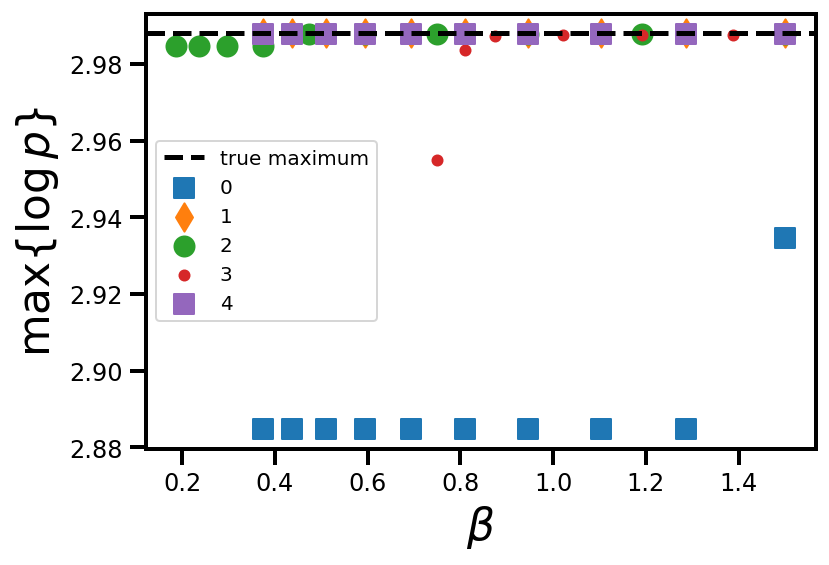

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
en

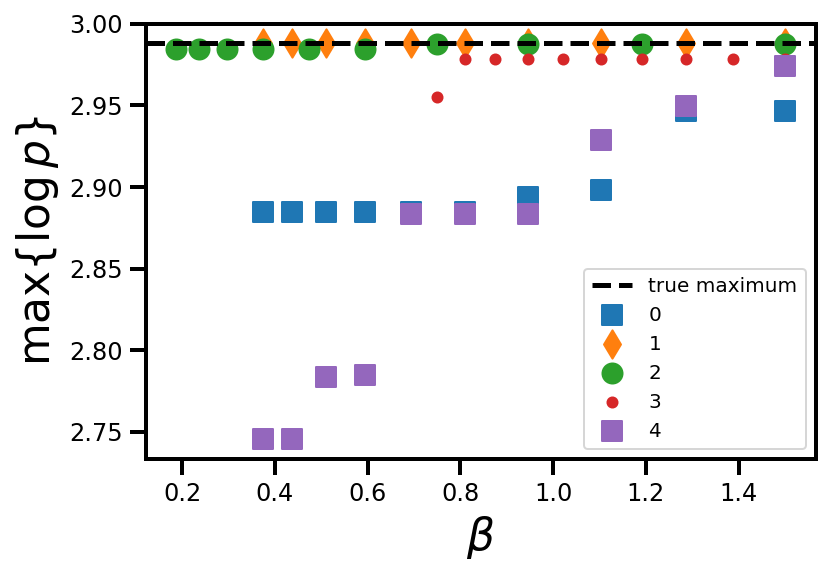

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.25       0.29163226 0.3401975  0.39685026 0.46293736
 0.54002987 0.62996052 0.73486725 0.85724398 1.        ] beta  0.29163225989402913 stage 2
0.29163225989402913 stage 3
0.3401975000435942 stage 4
0.3968502629920499 stage 5
0.46293735614364523 stage 6
0.540029869446153 stage 7
0.6299605249474366 stage 8
0.7348672461377994 stage 9
0.8572439828530729 stage 10
Inference mode is optimization. Maximum beta

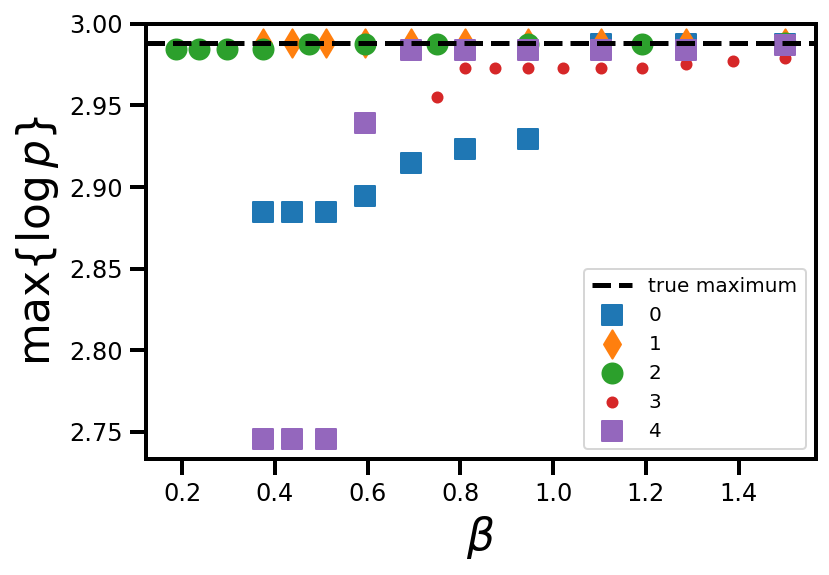

In [13]:
nes = [1,2,3]
ney = []
for ne in nes:
    ney.append(get_results(all_funcs[0],beta_max=1.5,verbose=False,view=True,sgd_steps=50,
                     train=True,train_uw=False,retrain=True,retrain_uw=False,
                              reg2=1.,reg1=1,knots_trainable=10,
                              random_knots=True,
                              rel_bw=1.5,a=100,loss_key=0,
                              mult_AF=True,
                              MSWD_max_iter=None,
                              batchsize=None,Nseeds=5,
                              n_ensemble=ne)
                )

Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.75       0.77436077 0.79951281 0.82548181 0.85229431
 0.87997771 0.9085603  0.93807127 0.9685408  1.        ] beta  0.7743607739820902 stage 2
0.7743607739820902 stage 3
0.7995128110428559 stage 4
0.8254818122236567 stage 5
0.8522943133621991 stage 6
0.8799777122075821 stage 7
0.9085602964160698 stage 8
0.9380712724561936 stage 9
0.9685407954527231 stage 10
Inference mode is optimization. Maximum beta is: 1.5
beta_schedule:  [0.         0.5        0.54002987 0.58326452 0.62996052 0.680395
 0.73486725 0.79370053 0.85724398 0.92587471 1.        ] beta  0.540029869446153 stage 2
0.540029869446153 stage 3
0.5832645197880583 stage 4
0.6299605249474366 stage 5
0.6803950000871885 stage 6
0.7348672461377994 stage 7
0.7937005259840998 stage 8
0.8572439828530729 stage 9
0.9258747122872905 stage 10
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mo

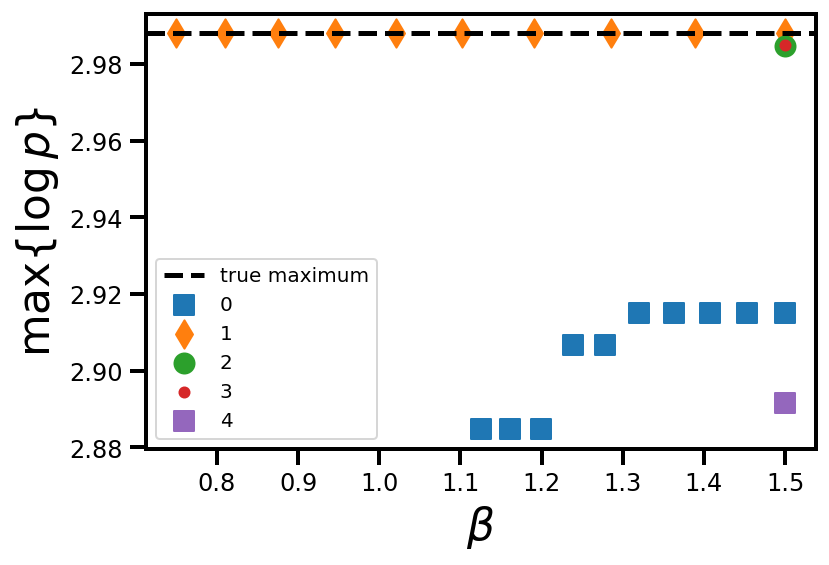

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
beta_schedule:  [0.         0.75       0.77436077 0.79951281 0.82548181 0.85229431
 0.87997771 0.9085603  0.93807127 0.9685408  1.        ] beta  0.7743607739820902 stage 2
0.7743607739820902 stage 3
0.7995128110428559 stage 4
0.8254818122236567 stage 5
0.8522943133621991 stage 6
0.8799777122075821 stage 7
0.9085602964160698 stage 8
0.9380712724561936 stage 9
0.9685407954527231 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
beta_schedule:  [0.         0.5        0.54002987 0.58326452 0.62996052 0.680395
 0.73486725 0.79370053 0.85724398 0.92587471 1.        ] beta  0.540029869446153 stage 2
0.540029869446153 stage 3
0.5832645197880583 stage 4
0.6299605249474366 stage 5
0.6803950000871885 stage 6
0.7348672461377994 stage 7
0.7937005259840998 stage 8
0.8572439828530729 stage 9
0.9258747122872905 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1

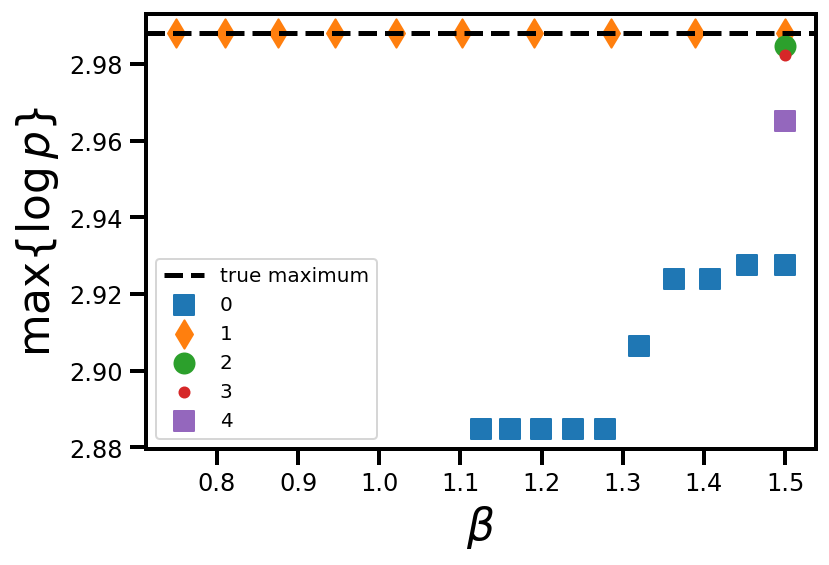

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.75       0.77436077 0.79951281 0.82548181 0.85229431
 0.87997771 0.9085603  0.93807127 0.9685408  1.        ] beta  0.7743607739820902 stage 2
0.7743607739820902 stage 3
0.7995128110428559 stage 4
0.8254818122236567 stage 5
0.8522943133621991 stage 6
0.8799777122075821 stage 7
0.9085602964160698 stage 8
0.9380712724561936 stage 9
0.9685407954527231 stage 10
Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.5        0.54002987 0.58326452 0.62996052 0.680395
 0.73486725 0.79370053 0.85724398 0.92587471 1.        ] beta  0.540029869446153 stage 2
0.540029869446153 stage 3
0.5832645197880583 stage 4
0.6299605249474366 stage 5
0.6803950000871885 stage 6
0.7348672461377994 stage 7
0.7937005259840998 stage 8
0.8572439828530729 stage 9
0.9258747122872905 stage 10
Inference mode is optimization. Maximum beta is: 1.5

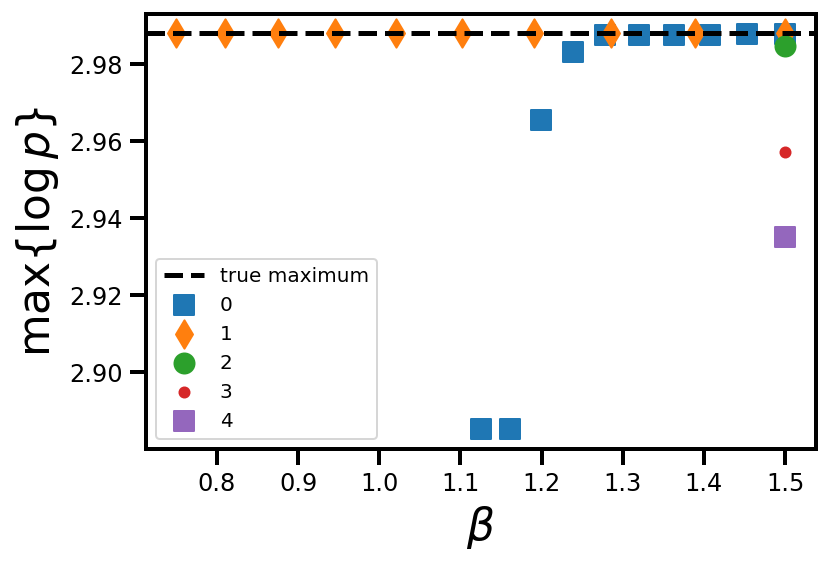

In [13]:
nes = [1,2,3] #ess 0.7, 0.5 just doesn't work, .7 doesnt' work on on bm=1 either, prior doesn't matter here
ney = []
for ne in nes:
    ney.append(get_results(all_funcs[0],beta_max=1.5,verbose=False,view=True,sgd_steps=50,
                     train=True,train_uw=False,retrain=True,retrain_uw=False,
                              reg2=1.,reg1=1,knots_trainable=10,
                              random_knots=True,
                              rel_bw=1.5,a=100,loss_key=0,
                              mult_AF=True,
                              MSWD_max_iter=None,
                              batchsize=None,Nseeds=5,
                              n_ensemble=ne)
                )

-----------------------BETA = 0.375-----------------------
SNF logZ_w:  2.408226197487488  SINF logZ_w:  3.9924247
SNF logZ_w:  2.8390049776928494  SINF logZ_w:  4.226924
SNF logZ_w:  2.7918224706212653  SINF logZ_w:  4.256256


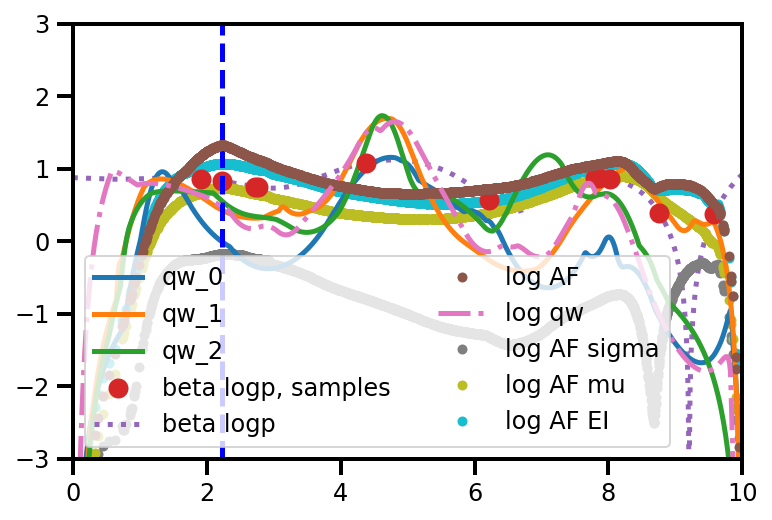

-----------------------BETA = 0.437-----------------------
SNF logZ_w:  2.9333128840507956  SINF logZ_w:  3.9924247
SNF logZ_w:  3.005009367035945  SINF logZ_w:  4.226924
SNF logZ_w:  2.9103465428688824  SINF logZ_w:  4.256256


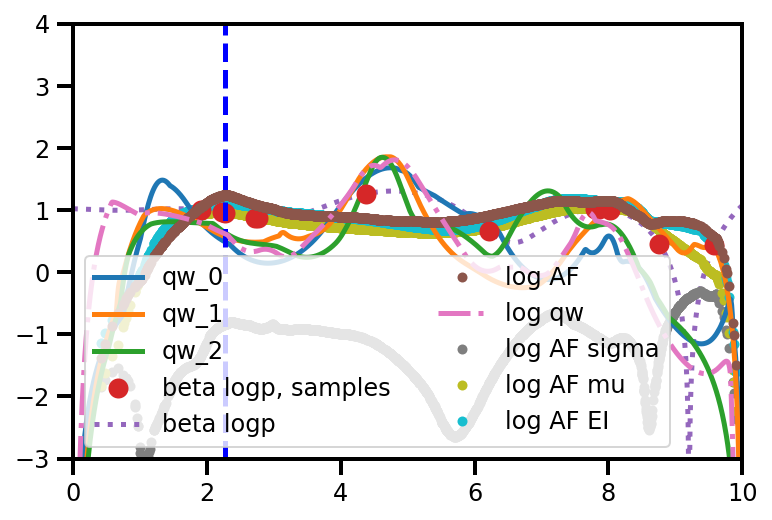

-----------------------BETA = 0.510-----------------------
SNF logZ_w:  3.2283782628503377  SINF logZ_w:  3.9924247
SNF logZ_w:  3.205464841379989  SINF logZ_w:  4.226924
SNF logZ_w:  3.1137029747055727  SINF logZ_w:  4.256256


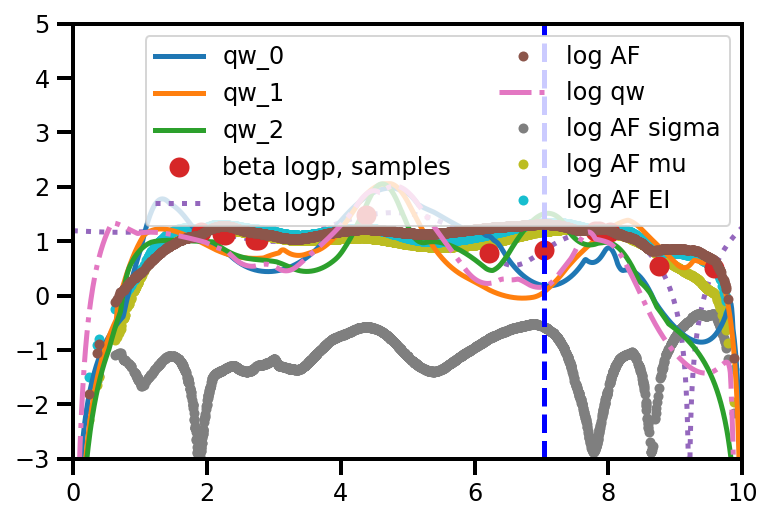

-----------------------BETA = 0.595-----------------------
SNF logZ_w:  3.2740213813768375  SINF logZ_w:  3.9924247
SNF logZ_w:  3.3736753158656025  SINF logZ_w:  4.226924
SNF logZ_w:  3.270897369642056  SINF logZ_w:  4.256256


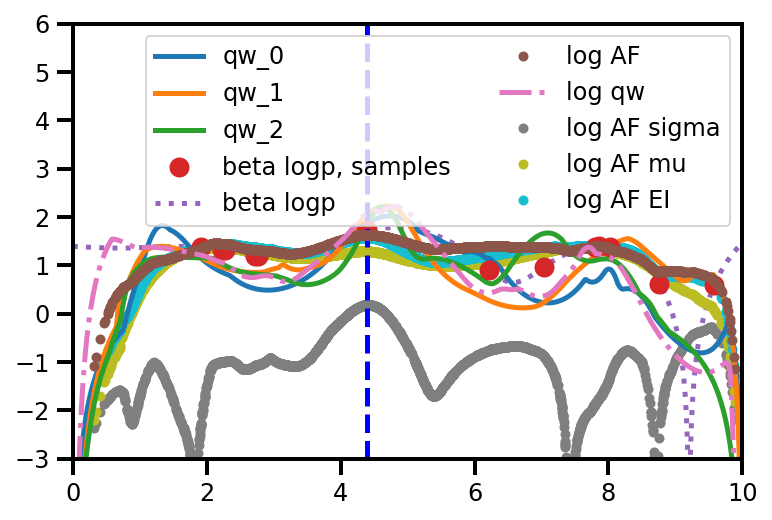

-----------------------BETA = 0.694-----------------------
SNF logZ_w:  3.5651285888269864  SINF logZ_w:  3.9924247
SNF logZ_w:  3.583842711448304  SINF logZ_w:  4.226924
SNF logZ_w:  3.593758074463646  SINF logZ_w:  4.256256


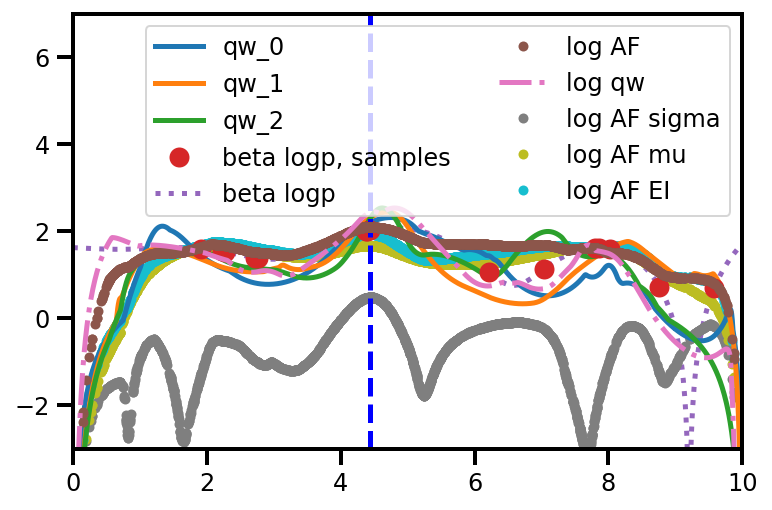

-----------------------BETA = 0.810-----------------------
SNF logZ_w:  4.082468017133589  SINF logZ_w:  3.9924247
SNF logZ_w:  3.8718871825275243  SINF logZ_w:  4.226924
SNF logZ_w:  3.811402823528102  SINF logZ_w:  4.256256


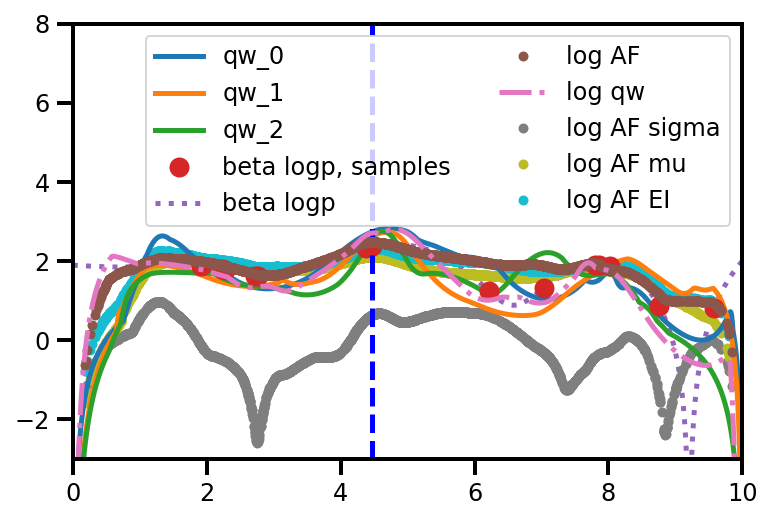

-----------------------BETA = 0.945-----------------------
SNF logZ_w:  4.44337273688339  SINF logZ_w:  3.9924247
SNF logZ_w:  4.190826438947712  SINF logZ_w:  4.226924
SNF logZ_w:  4.248064960631373  SINF logZ_w:  4.256256


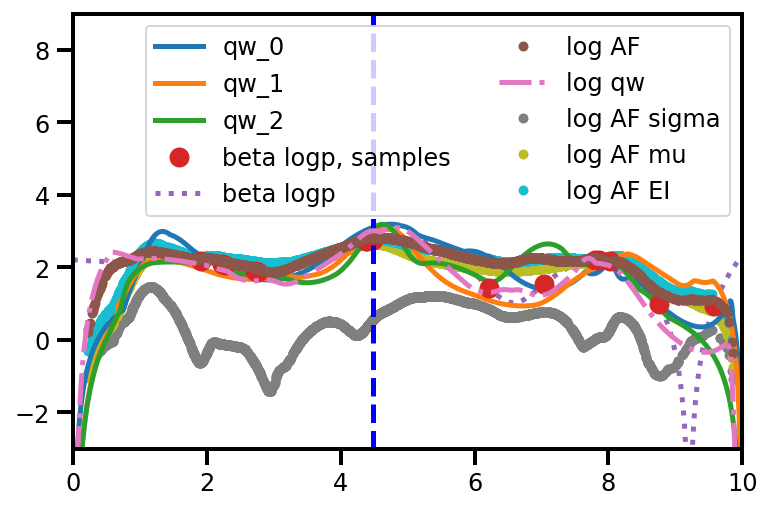

-----------------------BETA = 1.102-----------------------
SNF logZ_w:  4.798208219476914  SINF logZ_w:  3.9924247
SNF logZ_w:  4.565887428673783  SINF logZ_w:  4.226924
SNF logZ_w:  4.6153107048477375  SINF logZ_w:  4.256256


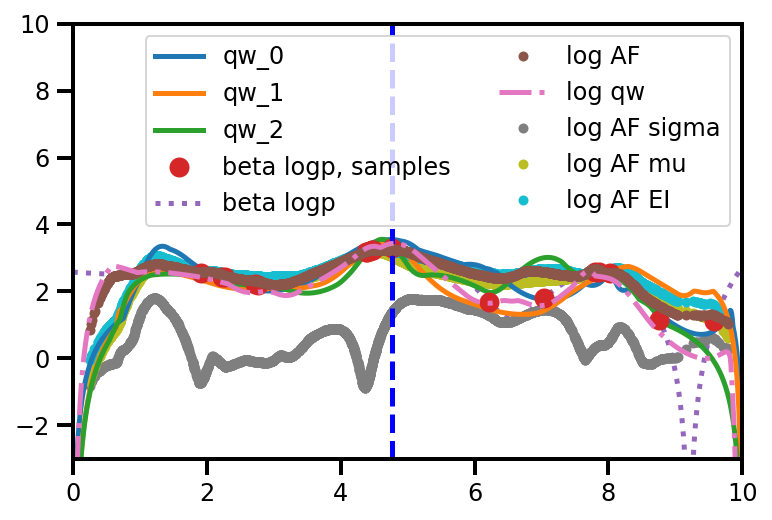

-----------------------BETA = 1.286-----------------------
SNF logZ_w:  5.2343568846937725  SINF logZ_w:  3.9924247
SNF logZ_w:  5.077631938879244  SINF logZ_w:  4.226924
SNF logZ_w:  4.910020849350512  SINF logZ_w:  4.256256


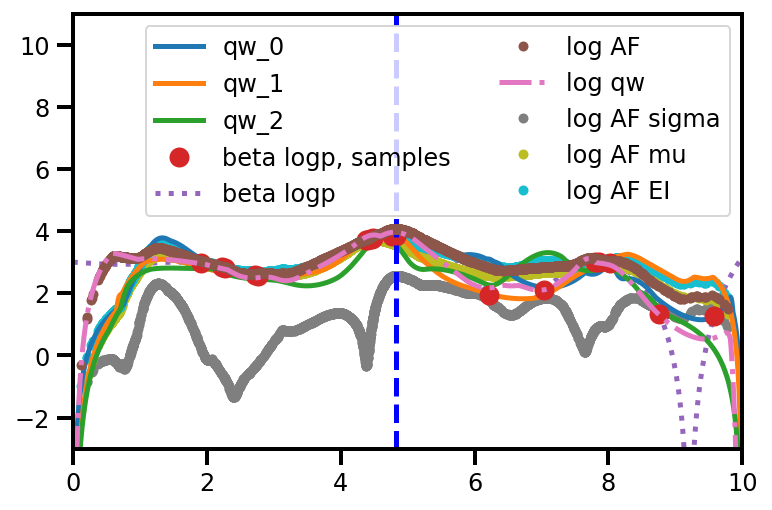

-----------------------BETA = 1.500-----------------------
SNF logZ_w:  5.735996235354904  SINF logZ_w:  3.9924247
SNF logZ_w:  5.649955799041981  SINF logZ_w:  4.226924
SNF logZ_w:  5.694876663410064  SINF logZ_w:  4.256256


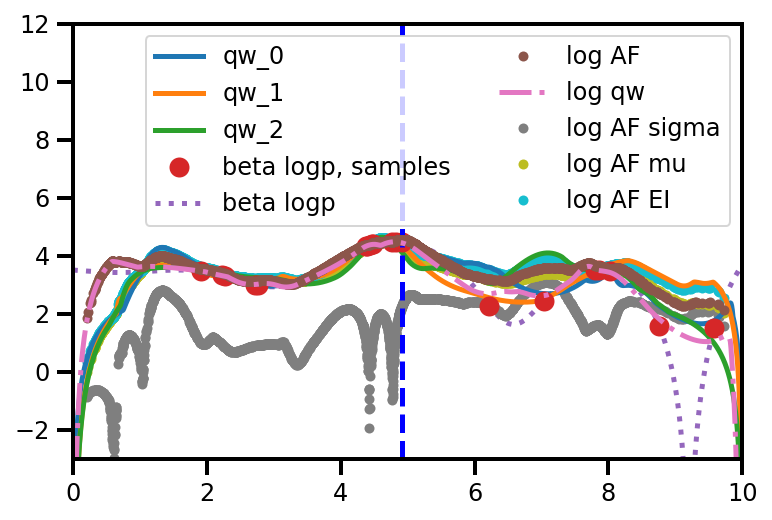

In [14]:
nEns = 3
xx=np.linspace(0,10,1000)
# try ensemble of 5(3), perhaps more points, higher d
# why improve w/ ensemble on? just seed?
trace=ney[nEns-1][0]
sinf=False
for beta_idx in range(1,len(trace['betas'][0])):
    print("-----------------------BETA = {0:.3f}-----------------------".format(trace['q_samples'][0]['q_beta_true']*trace['betas'][0][beta_idx]))
    for i in range(nEns):
        if(sinf):
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs_sinf'.format(beta_idx)][i])
            print("SINF logZ_w: ",lZz_w_SINF)
            lZz_w = lZz_w_SINF
        else:
            Zw = np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs'.format(beta_idx)][i])
            lZz_w=np.log(Zw) if Zw !=None else 0
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs_sinf'.format(beta_idx)][i])
            print("SNF logZ_w: ",lZz_w," SINF logZ_w: ",lZz_w_SINF)
        beta = trace['q_samples'][0]['q_beta_true']*trace['betas'][0][beta_idx]
        qwe = trace['q_models'][0]['q{0}_ensemble_w'.format(beta_idx)][i]
        sample_logqwe = qwe.evaluate_density(a2t(np.atleast_2d(xx)).T)
        plt.plot(xx,sample_logqwe+lZz_w,label='qw_{0}'.format(i))
    plt.plot(trace['q_samples'][0]['q{0}'.format(beta_idx)],beta*trace['logp'][0]['q{0}'.format(beta_idx)],
             ls=' ',marker='o',label='beta logp, samples')
    plt.plot(xx,beta*all_funcs[0]['f'](xx),ls=':',label='beta logp',zorder=-1)
    plt.axvline(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)][jnp.argmax(jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(beta_idx)]))],ls='--',c='b')
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(beta_idx)]),label='log AF',ls=' ',marker='.')
    plt.plot(xx,
              trace['q_models'][0]['q{0}_w'.format(beta_idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)+np.log(trace['logZ'][0]['q{0}_w_trainable'.format(beta_idx)]),
             ls='-.',label='log qw')
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_sigma'.format(beta_idx)]),label='log AF sigma',ls=' ',marker='.',zorder=-1)
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_mu'.format(beta_idx)]),label='log AF mu',ls=' ',marker='.',zorder=-1)
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_ei'.format(beta_idx)]),label='log AF EI',ls=' ',marker='.',zorder=-1)

    plt.ylim(-3,2+2*beta_idx/2)
    plt.xlim(0,10)
    plt.legend(prop={"size":12},ncol=2)
#     plt.savefig('./newAF_plots/nes{1}_beta_idx{0}.png'.format(beta_idx,nEns))
    plt.show()

-----------------------BETA = 1.125-----------------------
SNF logZ_w:  4.539172593110361  SINF logZ_w:  4.1088285
SNF logZ_w:  4.636992428961478  SINF logZ_w:  4.2272434
SNF logZ_w:  4.609240565060491  SINF logZ_w:  4.224161


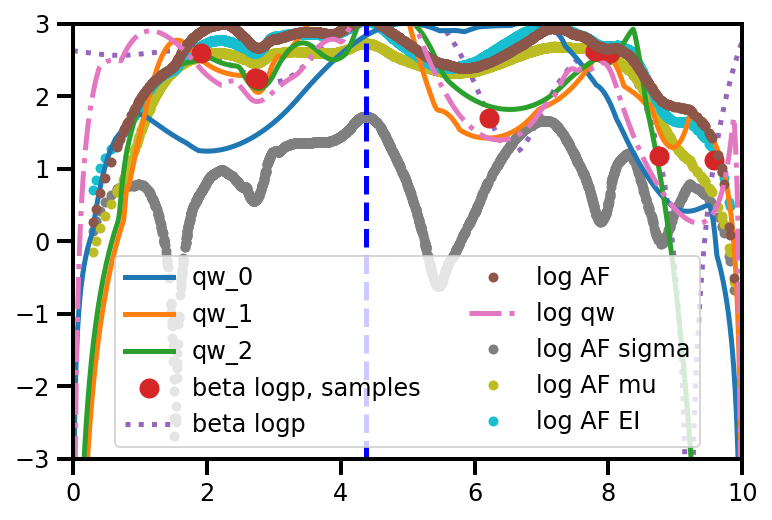

-----------------------BETA = 1.162-----------------------
SNF logZ_w:  5.135430363230249  SINF logZ_w:  4.1088285
SNF logZ_w:  4.620618782036626  SINF logZ_w:  4.2272434
SNF logZ_w:  4.7149682061502824  SINF logZ_w:  4.224161


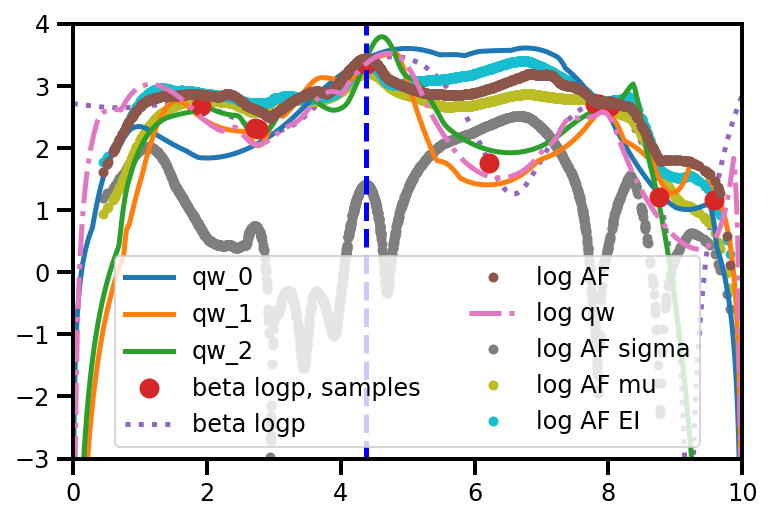

-----------------------BETA = 1.199-----------------------
SNF logZ_w:  5.395782953282722  SINF logZ_w:  4.1088285
SNF logZ_w:  4.673319348381118  SINF logZ_w:  4.2272434
SNF logZ_w:  4.706565399349259  SINF logZ_w:  4.224161


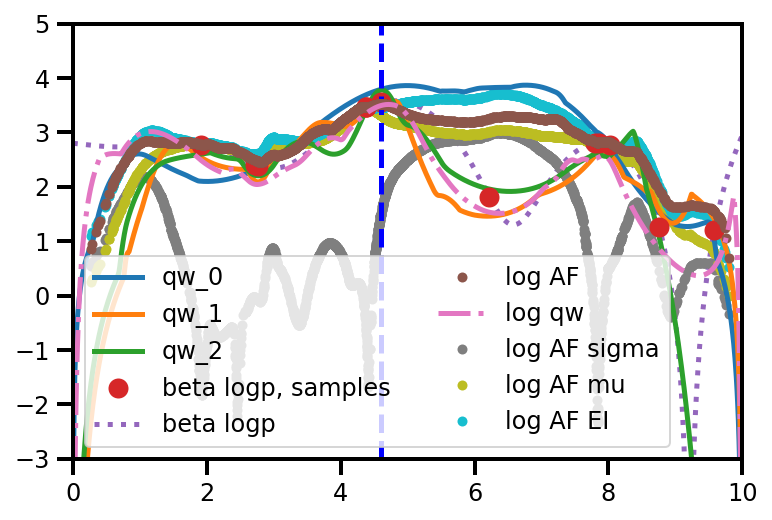

-----------------------BETA = 1.238-----------------------
SNF logZ_w:  5.42751262764797  SINF logZ_w:  4.1088285
SNF logZ_w:  4.8369732180594625  SINF logZ_w:  4.2272434
SNF logZ_w:  4.85402395790671  SINF logZ_w:  4.224161


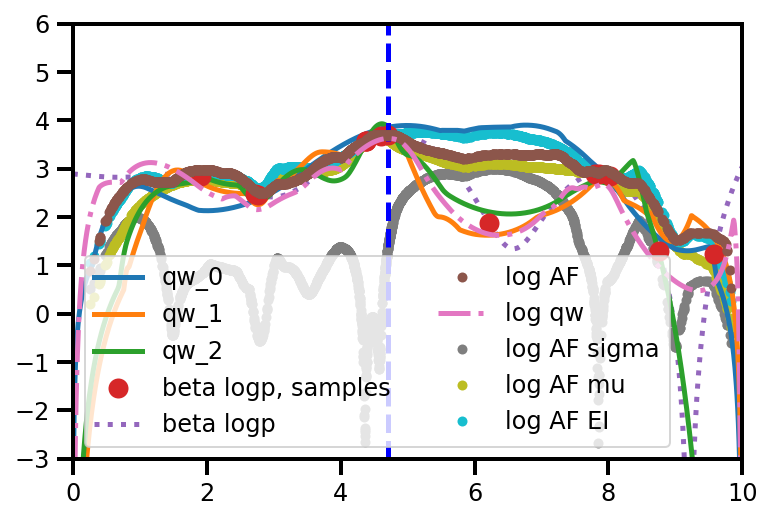

-----------------------BETA = 1.278-----------------------
SNF logZ_w:  5.529028888084675  SINF logZ_w:  4.1088285
SNF logZ_w:  4.991837484067701  SINF logZ_w:  4.2272434
SNF logZ_w:  5.005940861480076  SINF logZ_w:  4.224161


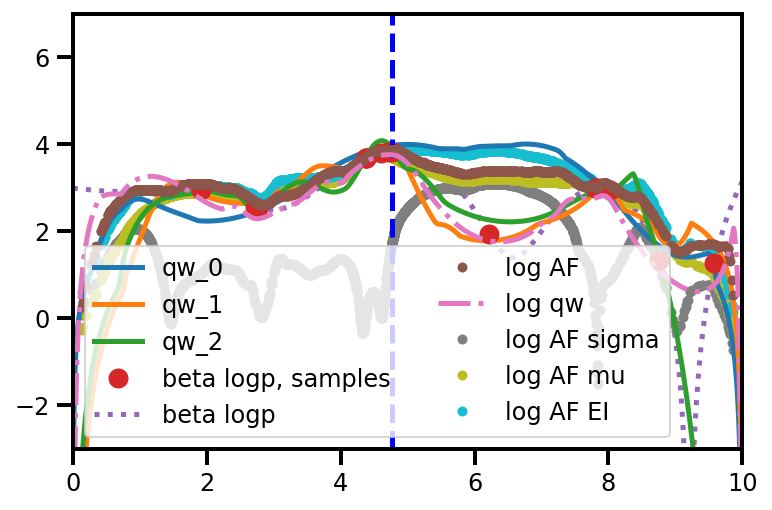

-----------------------BETA = 1.320-----------------------
SNF logZ_w:  5.604374912604006  SINF logZ_w:  4.1088285
SNF logZ_w:  5.1646012819248  SINF logZ_w:  4.2272434
SNF logZ_w:  4.976923985637841  SINF logZ_w:  4.224161


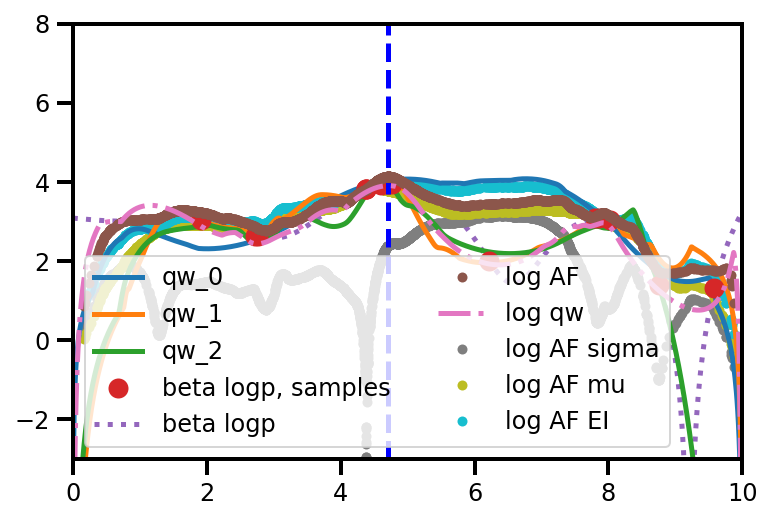

-----------------------BETA = 1.363-----------------------
SNF logZ_w:  5.72852470809369  SINF logZ_w:  4.1088285
SNF logZ_w:  5.30131389480834  SINF logZ_w:  4.2272434
SNF logZ_w:  5.200220547047229  SINF logZ_w:  4.224161


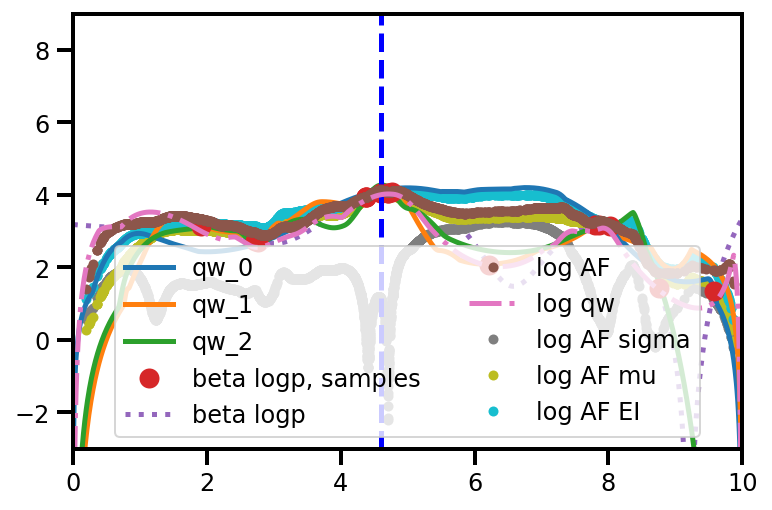

-----------------------BETA = 1.407-----------------------
SNF logZ_w:  5.859617265009289  SINF logZ_w:  4.1088285
SNF logZ_w:  5.4523191095035  SINF logZ_w:  4.2272434
SNF logZ_w:  5.289557030190304  SINF logZ_w:  4.224161


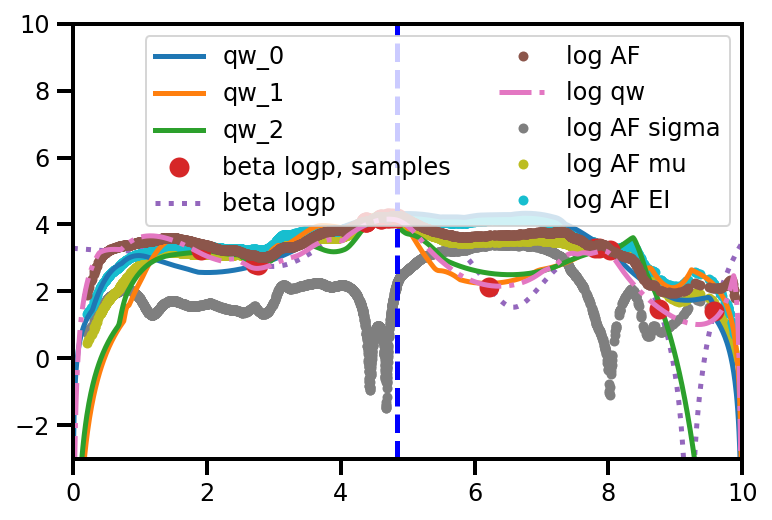

-----------------------BETA = 1.453-----------------------
SNF logZ_w:  5.990594875840637  SINF logZ_w:  4.1088285
SNF logZ_w:  5.512483115658734  SINF logZ_w:  4.2272434
SNF logZ_w:  5.3165569161371735  SINF logZ_w:  4.224161


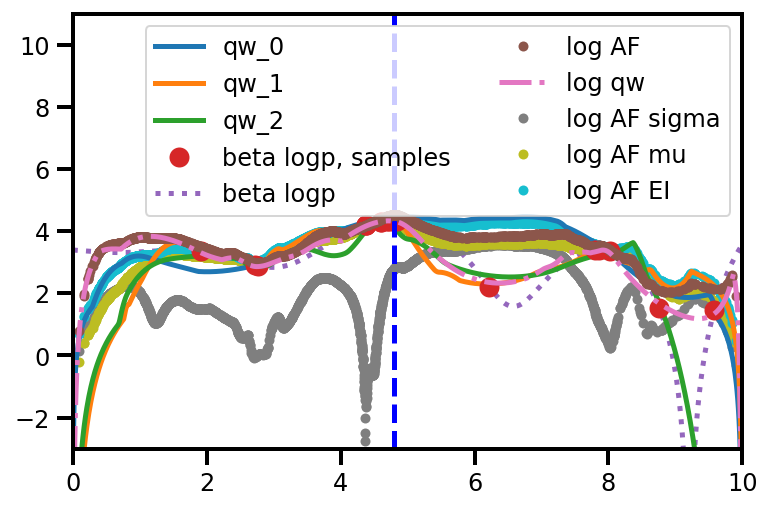

-----------------------BETA = 1.500-----------------------
SNF logZ_w:  6.038918966167624  SINF logZ_w:  4.1088285
SNF logZ_w:  5.585194099236822  SINF logZ_w:  4.2272434
SNF logZ_w:  5.6248917775207365  SINF logZ_w:  4.224161


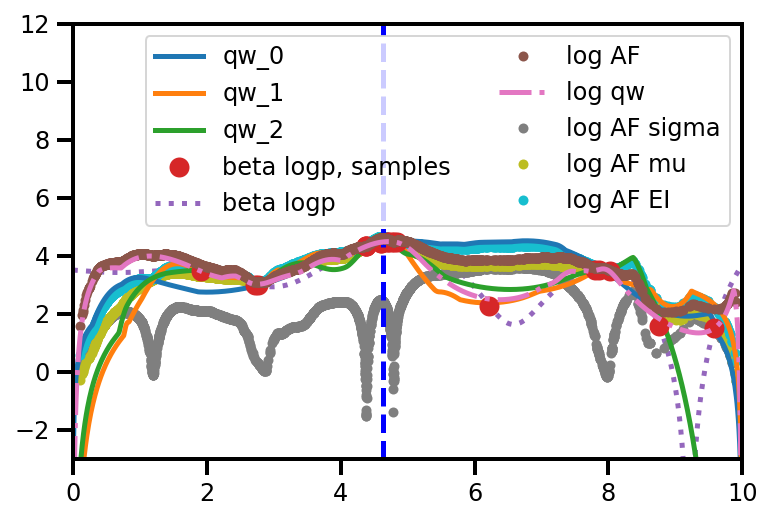

In [14]:
nEns = 3 #0.7
xx=np.linspace(0,10,1000)
# try ensemble of 5(3), perhaps more points, higher d
# why improve w/ ensemble on? just seed?
trace=ney[nEns-1][0]
sinf=False
for beta_idx in range(1,len(trace['betas'][0])):
    print("-----------------------BETA = {0:.3f}-----------------------".format(trace['q_samples'][0]['q_beta_true']*trace['betas'][0][beta_idx]))
    for i in range(nEns):
        if(sinf):
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs_sinf'.format(beta_idx)][i])
            print("SINF logZ_w: ",lZz_w_SINF)
            lZz_w = lZz_w_SINF
        else:
            Zw = np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs'.format(beta_idx)][i])
            lZz_w=np.log(Zw) if Zw !=None else 0
            lZz_w_SINF= np.array(trace['logZ'][0]['q{0}_ensemble_w_Zs_sinf'.format(beta_idx)][i])
            print("SNF logZ_w: ",lZz_w," SINF logZ_w: ",lZz_w_SINF)
        beta = trace['q_samples'][0]['q_beta_true']*trace['betas'][0][beta_idx]
        qwe = trace['q_models'][0]['q{0}_ensemble_w'.format(beta_idx)][i]
        sample_logqwe = qwe.evaluate_density(a2t(np.atleast_2d(xx)).T)
        plt.plot(xx,sample_logqwe+lZz_w,label='qw_{0}'.format(i))
    plt.plot(trace['q_samples'][0]['q{0}'.format(beta_idx)],beta*trace['logp'][0]['q{0}'.format(beta_idx)],
             ls=' ',marker='o',label='beta logp, samples')
    plt.plot(xx,beta*all_funcs[0]['f'](xx),ls=':',label='beta logp',zorder=-1)
    plt.axvline(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)][jnp.argmax(jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(beta_idx)]))],ls='--',c='b')
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF'.format(beta_idx)]),label='log AF',ls=' ',marker='.')
    plt.plot(xx,
              trace['q_models'][0]['q{0}_w'.format(beta_idx)].evaluate_density(a2t(np.atleast_2d(xx)).T)+np.log(trace['logZ'][0]['q{0}_w_trainable'.format(beta_idx)]),
             ls='-.',label='log qw')
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_sigma'.format(beta_idx)]),label='log AF sigma',ls=' ',marker='.',zorder=-1)
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_mu'.format(beta_idx)]),label='log AF mu',ls=' ',marker='.',zorder=-1)
    plt.plot(trace['q_samples'][0]['q{0}_AF_props'.format(beta_idx)],
             jnp.log(trace['importance_weights'][0]['q{0}_AF_ei'.format(beta_idx)]),label='log AF EI',ls=' ',marker='.',zorder=-1)

    plt.ylim(-3,2+2*beta_idx/2)
    plt.xlim(0,10)
    plt.legend(prop={"size":12},ncol=2)
#     plt.savefig('./newAF_plots/nes{1}_beta_idx{0}.png'.format(beta_idx,nEns))
    plt.show()

### Increase batchsize

In [16]:
all_funcs

[{'f': <function __main__.log_sc(x)>,
  'opt': -9.50835,
  'max': 10.3368,
  'bounds': [[0.0], [10.0]]},
 {'f': <function __main__.log_ack2(x)>,
  'opt': 0.0,
  'max': 22.718281828459045,
  'bounds': [[-5.0, -5.0], [10.0, 10.0]]},
 {'f': <function __main__.log_ack5(x)>,
  'opt': 0.0,
  'max': 22.718281828459045,
  'bounds': [[-5.0, -5.0, -5.0, -5.0, -5.0], [10.0, 10.0, 10.0, 10.0, 10.0]]},
 {'f': <function __main__.log_ack10(x)>,
  'opt': 0.0,
  'max': 22.718281828459045,
  'bounds': [[-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0],
   [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]}]

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.5        0.51857752 0.53784529 0.55782896 0.57855512
 0.60005136 0.62234629 0.6454696  0.66945205 0.69432557 0.72012327
 0.74687948 0.77462982 0.80341123 0.83326201 0.86422189 0.8963321
 0.92963536 0.964176   1.        ] beta  0.5185775222230959 stage 2
0.5185775222230959 stage 3
0.5378452931100912 stage 4
0.5578289588807719 stage 5
0.5785551186413599 stage 6
0.6000513597890516 stage 7
0.6223462947320116 stage 8
0.6454695989737025 stage 9
0.6694520506122361 stage 10
0.6943255713073281 stage 11
0.7201232687693795 stage 12
0.7468794808272429 stage 13
0.7746298211333279 stage 14
0.8034112265668824 stage 15
0.8332620063985445 stage 16
0.8642218932816056 stage 17
0.8963320961378558 stage 18
0.9296353550084062 stage 19
0.9641759979424951 stage 20
value of max logp = 2.872130870819092, at [0.03508186 2.0287929 ], with 20 levels and 30 total calls
value of max logp = 2.8721308708

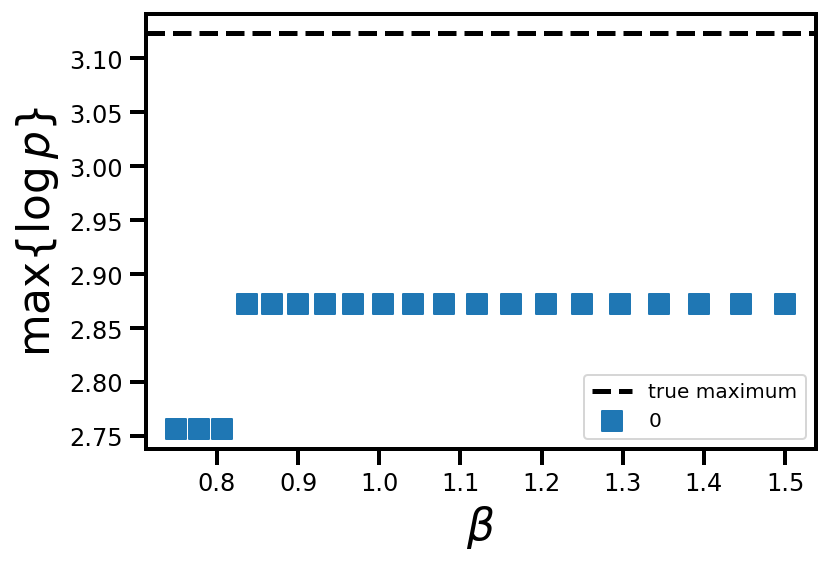

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.5        0.51857752 0.53784529 0.55782896 0.57855512
 0.60005136 0.62234629 0.6454696  0.66945205 0.69432557 0.72012327
 0.74687948 0.77462982 0.80341123 0.83326201 0.86422189 0.8963321
 0.92963536 0.964176   1.        ] beta  0.5185775222230959 stage 2
0.5185775222230959 stage 3
0.5378452931100912 stage 4
0.5578289588807719 stage 5
0.5785551186413599 stage 6
0.6000513597890516 stage 7
0.6223462947320116 stage 8
0.6454695989737025 stage 9
0.6694520506122361 stage 10
0.6943255713073281 stage 11
0.7201232687693795 stage 12
0.7468794808272429 stage 13
0.7746298211333279 stage 14
0.8034112265668824 stage 15
0.8332620063985445 stage 16
0.8642218932816056 stage 17
0.8963320961378558 stage 18
0.9296353550084062 stage 19
0.9641759979424951 stage 20
value of max logp = 2.816762685775757, at [-1.7993717   0.87237024], with 20 levels and 30 total calls
value of max logp = 2.81676268

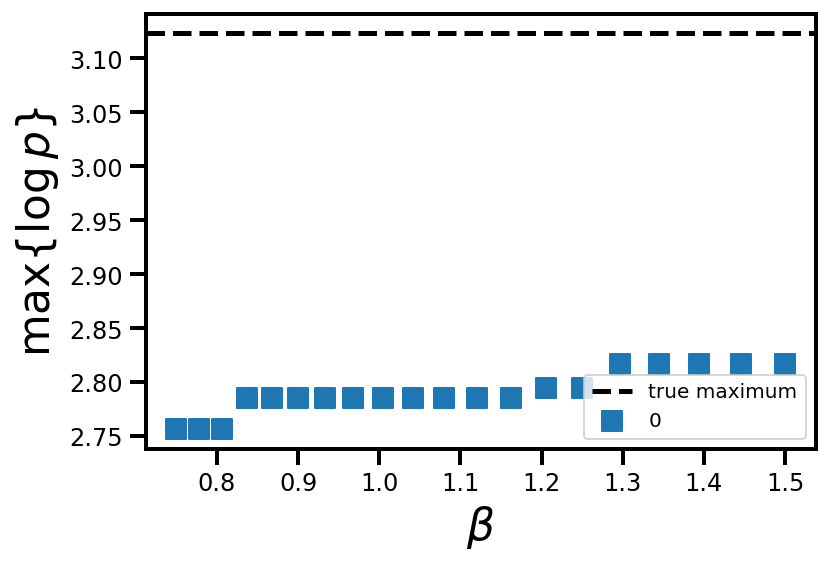

Inference mode is optimization. Maximum beta is: 1.5
ensemble 0
ensemble 1
ensemble 2
beta_schedule:  [0.         0.5        0.51857752 0.53784529 0.55782896 0.57855512
 0.60005136 0.62234629 0.6454696  0.66945205 0.69432557 0.72012327
 0.74687948 0.77462982 0.80341123 0.83326201 0.86422189 0.8963321
 0.92963536 0.964176   1.        ] beta  0.5185775222230959 stage 2
0.5185775222230959 stage 3
0.5378452931100912 stage 4
0.5578289588807719 stage 5
0.5785551186413599 stage 6
0.6000513597890516 stage 7
0.6223462947320116 stage 8
0.6454695989737025 stage 9
0.6694520506122361 stage 10
0.6943255713073281 stage 11
0.7201232687693795 stage 12
0.7468794808272429 stage 13
0.7746298211333279 stage 14
0.8034112265668824 stage 15
0.8332620063985445 stage 16
0.8642218932816056 stage 17
0.8963320961378558 stage 18
0.9296353550084062 stage 19
0.9641759979424951 stage 20
value of max logp = 2.761418581008911, at [-2.095219   0.6627207], with 20 levels and 30 total calls
value of max logp = 2.7614185810

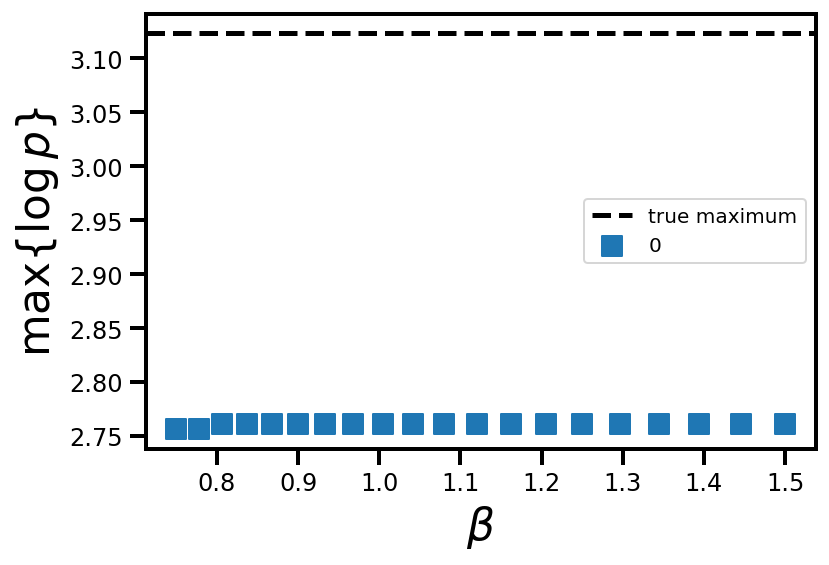

In [16]:
bss = [1,.1,10]
bsy = []
for bs in bss:
    bsy.append(get_results(all_funcs[1],beta_max=1.5,verbose=False,view=True,sgd_steps=50,
                     train=True,train_uw=False,retrain=True,retrain_uw=False,
                              reg2=1.,reg1=1,knots_trainable=10,
                              random_knots=True,
                              rel_bw=1.5,a=100,loss_key=0,
                              mult_AF=True,
                              MSWD_max_iter=None,
                              Nseeds=1,fomo=bs,
                              n_ensemble=3)
                )